<a id=top-page></a>
# Benefits of nonlinear decoding of QoIs demonstrated on a synthetic dataset

This Jupyter notebook requires running three Python scripts first:

- `illustrative-example-costs.py`
- `illustrative-example-linear-reconstruction-from-a-subspace.py`
- `illustrative-example-nonlinear-reconstruction-from-a-subspace.py`

### Table of contents

- [**Generate a synthetic 2D dataset**](#2D-data)
- [**Visualize the 2D dataset and the dependent variables**](#2D-data-visualize)
- [**Initialize the QoI-aware encoders-decoders**](#initialize)
- [**Visualize MSE versus the cost function assessment**](#MSE-vs-L)
- [**Linear decoding may not be optimal for representing target dependent variables**](#2D-data-linear-vs-nonlinear-decoding)
- [**Visualize 1D projections**](#visualize-1D-projections)


***

In [1]:
%run -i imports.py
%matplotlib inline

In [2]:
plot_save_location = '../figures/'
results_save_location = '../results-synthetic-data/'

In [3]:
random_seed = 100

In [4]:
angle_list = [i for i in range(0,180)]
bandwidth_values = np.logspace(-7, 3, 200)

<a id=2D-data></a>
***

## Generate a synthetic 2D dataset

[Go to the top ↑](#top-page)

In [5]:
n_points = 2000
np.random.seed(seed=10)
mean = [0,0]
covariance = [[2.5, 0.52], [0.52, 0.2]]
x_noise, y_noise = np.random.multivariate_normal(mean, covariance, n_points).T
dataset_2D = np.column_stack((x_noise, y_noise))
dataset_2D_normalized, centers_2D, scales_2D = preprocess.center_scale(dataset_2D, scaling='-1to1')

dataset_2D_normalized = dataset_2D_normalized - np.mean(dataset_2D_normalized, axis=0)

In [6]:
phi_1 = dataset_2D_normalized[:,0]**2 + 3*dataset_2D_normalized[:,0]
phi_2 = dataset_2D_normalized[:,0] * dataset_2D_normalized[:,1]
phi_3 = np.sin(dataset_2D_normalized[:,0]) + np.abs(dataset_2D_normalized[:,1])
phi_4 = np.exp(-(dataset_2D_normalized[:,0]**2+dataset_2D_normalized[:,1]**2) / (2.0 * 0.3**2))

angle = 137.5
print('Angle:\t' + str(angle) + ' degrees')

theta = np.deg2rad(angle)
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
rotated_dataset = np.dot(dataset_2D_normalized, rotation_matrix)

phi_5 = np.sin(rotated_dataset[:,0]*4+0.4)
phi_5_normalized, centers_phi, scales_phi = preprocess.center_scale(phi_5[:,None], scaling='-1to1')

phi_2D = np.column_stack((phi_1, phi_2, phi_3, phi_4))
phi_2D_normalized, centers_phi, scales_phi = preprocess.center_scale(phi_2D, scaling='-1to1')

Angle:	137.5 degrees


<a id=2D-data-visualize></a>

***

## Visualize the 2D dataset and the dependent variables

[Go to the top ↑](#top-page)

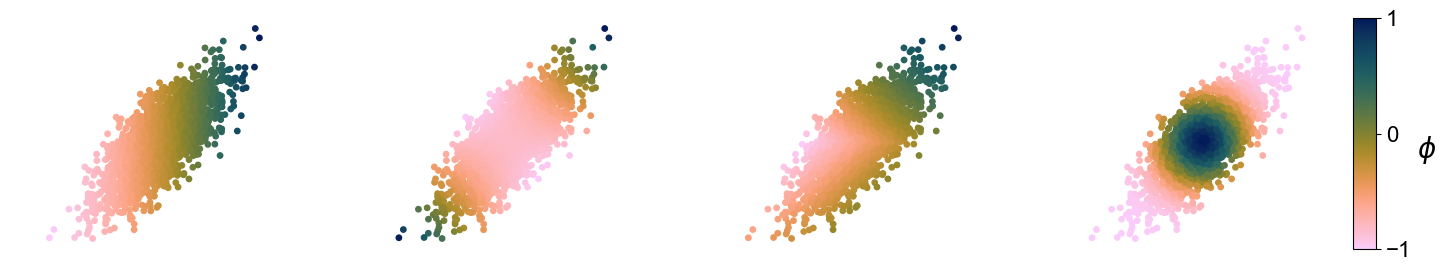

In [7]:
cmap = cmc.batlow_r

fig = plt.figure(figsize=(18, 3))
spec = fig.add_gridspec(ncols=4, nrows=1, width_ratios=[1,1,1,1.2], height_ratios=[1])

point_size = 15

figure_b = fig.add_subplot(spec[0,0])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=phi_2D_normalized[:,0],
                   cmap=cmap)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

figure_c = fig.add_subplot(spec[0,1])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=phi_2D_normalized[:,1],
                   cmap=cmap)
plt.axis('equal');
plt.xticks([])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

figure_d = fig.add_subplot(spec[0,2])
scat = plt.scatter(dataset_2D_normalized[:,0], 
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=phi_2D_normalized[:,2],
                   cmap=cmap)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

figure_e = fig.add_subplot(spec[0,3])
scat = plt.scatter(dataset_2D_normalized[:,0], 
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=phi_2D_normalized[:,3],
                   cmap=cmap)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
cbar = plt.colorbar(scat, ticks=[-1,0,1], aspect=10)
cbar.set_label('$\phi$', fontsize=20, rotation=0, horizontalalignment='left', **csfont)
for t in cbar.ax.get_yticklabels():
    t.set_fontproperties('Arial')
    t.set_fontsize(16)
        
plt.savefig(plot_save_location + 'synthetic-2D-data-with-various-depvars.png', dpi=400, bbox_inches='tight')

<a id=initialize></a>
***

## Initialize the QoI-aware encoders-decoders

[Go to the top ↑](#top-page)

In [8]:
n_epochs = 3000

In [9]:
# QoI = phi_2D_normalized[:,0:1]
# QoI = phi_2D_normalized[:,1:2]
QoI = phi_2D_normalized[:,2:3]
# QoI = phi_2D_normalized[:,3:4]

In [10]:
qoi_aware_linear = QoIAwareProjection(dataset_2D_normalized,
                                               n_components=1,
                                               projection_independent_outputs=QoI,
                                               activation_decoder='linear',
                                               decoder_interior_architecture=(2,2),
                                               n_epochs=n_epochs,
                                               random_seed=random_seed)

In [11]:
qoi_aware_linear.train()

  0%|                                                  | 0/3000 [00:00<?, ?it/s]/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
100%|██████████████████████████████████████| 3000/3000 [00:23<00:00, 125.83it/s]


<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/matplotlib/pyplot.py'>

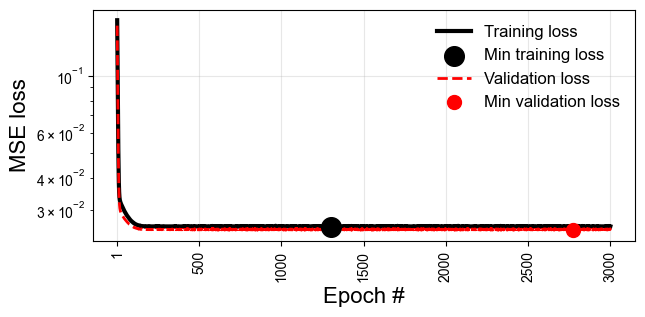

In [12]:
qoi_aware_linear.plot_losses(markevery=500, figure_size=(7,3))

In [13]:
qoi_aware_nonlinear = QoIAwareProjection(dataset_2D_normalized,
                                               n_components=1,
                                               projection_independent_outputs=QoI,
                                               activation_decoder='tanh',
                                               decoder_interior_architecture=(2,2),
                                               n_epochs=n_epochs,
                                               random_seed=random_seed)

In [14]:
qoi_aware_nonlinear.train()

100%|██████████████████████████████████████| 3000/3000 [00:24<00:00, 120.72it/s]


<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/matplotlib/pyplot.py'>

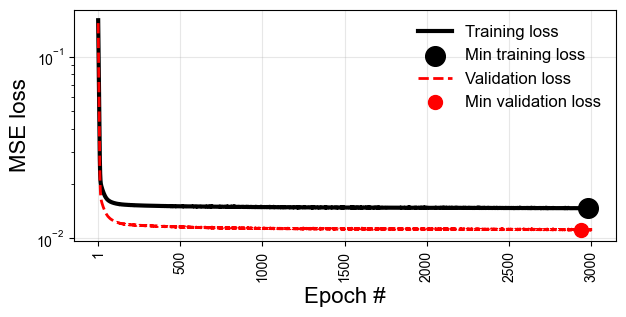

In [15]:
qoi_aware_nonlinear.plot_losses(markevery=500, figure_size=(7,3))

In [16]:
basis_linear = qoi_aware_linear.get_best_basis()

Minimum training loss:		0.025738663143581815
Minimum training loss at epoch:	1301


In [17]:
basis_nonlinear = qoi_aware_nonlinear.get_best_basis()

Minimum training loss:		0.014633753854367468
Minimum training loss at epoch:	2981


(-1.1, 1.1)

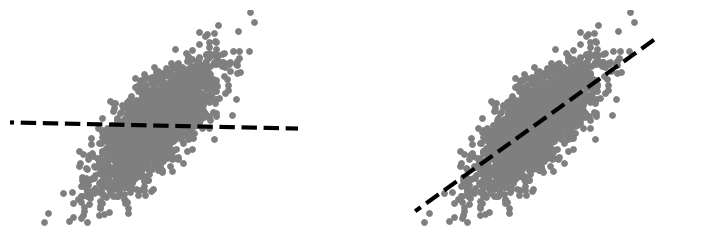

In [18]:
fig = plt.figure(figsize=(9, 3))
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1,1.2], height_ratios=[1])

point_size = 15

subspace_color = '#ff0000'
subspace_color = 'k'

figure_a = fig.add_subplot(spec[0,0])
plt.scatter(dataset_2D_normalized[:,0],
            dataset_2D_normalized[:,1],
            s=point_size,
            c='#7f7f7f')
plt.axis('equal');
plt.xticks([])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
basis_PCA = np.array([[np.sqrt(2),np.sqrt(2)], [np.sqrt(2),np.sqrt(2)]])
plt.plot([-basis_linear[0,0]*1.4, basis_linear[0,0]*1.4], [-basis_linear[1,0]*1.4, basis_linear[1,0]*1.4], '--', c=subspace_color, lw=3)
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])


figure_a = fig.add_subplot(spec[0,1])
plt.scatter(dataset_2D_normalized[:,0],
            dataset_2D_normalized[:,1],
            s=point_size,
            c='#7f7f7f')
plt.axis('equal');
plt.xticks([])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
basis_PCA = np.array([[np.sqrt(2),np.sqrt(2)], [np.sqrt(2),np.sqrt(2)]])
plt.plot([-basis_nonlinear[0,0]*1.4, basis_nonlinear[0,0]*1.4], [-basis_nonlinear[1,0]*1.4, basis_nonlinear[1,0]*1.4], '--', c=subspace_color, lw=3)
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])

<a id=MSE-vs-L></a>
***

## Visualize MSE versus the cost function assessment

[Go to the top ↑](#top-page)

In [19]:
filename = results_save_location + 'synthetic-dataset-costs-phi-1.csv'
if os.path.exists(filename):
    costs_phi_1 = pd.read_csv(filename, sep = ',', header=None).to_numpy()
else:
    print('Please run the `illustrative-example-costs.py` script first.')

In [20]:
filename = results_save_location + 'synthetic-dataset-costs-phi-2.csv'
if os.path.exists(filename):
    costs_phi_2 = pd.read_csv(filename, sep = ',', header=None).to_numpy()
else:
    print('Please run the `illustrative-example-costs.py` script first.')

In [21]:
filename = results_save_location + 'synthetic-dataset-costs-phi-3.csv'
if os.path.exists(filename):
    costs_phi_3 = pd.read_csv(filename, sep = ',', header=None).to_numpy()
else:
    print('Please run the `illustrative-example-costs.py` script first.')

In [22]:
filename = results_save_location + 'synthetic-dataset-costs-phi-4.csv'
if os.path.exists(filename):
    costs_phi_4 = pd.read_csv(filename, sep = ',', header=None).to_numpy()
else:
    print('Please run the `illustrative-example-costs.py` script first.')

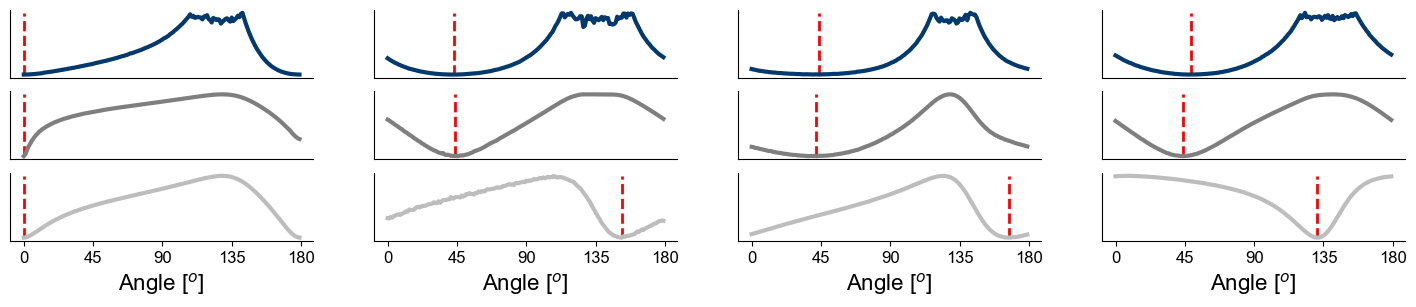

In [23]:
fig = plt.figure(figsize=(18, 3))
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=[1,1,1,1], height_ratios=[1,1,1])

lw = 3
s = 200
fontsize = 16

color_cost = '#03396c'
color_MSE_nonlinear = '#7f7f7f'
color_MSE_linear = '#bdbdbd'

# Phi-1 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

figure = fig.add_subplot(spec[0,0])
plt.semilogy(angle_list, costs_phi_1, '-', lw=lw, zorder=5, color=color_cost)
idx_min_phi_1,_ = np.where(costs_phi_1==np.min(costs_phi_1))
idx_min_phi_1 = idx_min_phi_1[0]
plt.plot([angle_list[idx_min_phi_1],angle_list[idx_min_phi_1]], [np.min(costs_phi_1),np.max(costs_phi_1)], '--', c='r', lw=2, zorder=2)
plt.xticks([])
plt.yticks([])
plt.minorticks_off()
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

figure = fig.add_subplot(spec[1,0])
MSE_nonlinear_phi_1 = pd.read_csv(results_save_location + 'synthetic-dataset-nonlinear-reconstruction-from-subspace-phi-1-MSE-loss.csv', sep = ',', header=None).to_numpy()
idx_min_MSE,_ = np.where(MSE_nonlinear_phi_1==np.min(MSE_nonlinear_phi_1))
idx_min_MSE = idx_min_MSE[0]
plt.semilogy(angle_list, MSE_nonlinear_phi_1, '-', lw=lw, zorder=5, color=color_MSE_nonlinear)
plt.plot([angle_list[idx_min_MSE],angle_list[idx_min_MSE]], [np.min(MSE_nonlinear_phi_1),np.max(MSE_nonlinear_phi_1)], '--', c='r', lw=2, zorder=2)
plt.xticks([])
plt.yticks([])
plt.minorticks_off()
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

figure = fig.add_subplot(spec[2,0])
MSE_linear_phi_1 = pd.read_csv(results_save_location + 'synthetic-dataset-linear-reconstruction-from-subspace-phi-1-MSE-loss.csv', sep = ',', header=None).to_numpy()
idx_min_MSE,_ = np.where(MSE_linear_phi_1==np.min(MSE_linear_phi_1))
idx_min_MSE = idx_min_MSE[0]
plt.semilogy(angle_list, MSE_linear_phi_1, '-', lw=lw, zorder=5, color=color_MSE_linear)
plt.plot([angle_list[idx_min_MSE],angle_list[idx_min_MSE]], [np.min(MSE_linear_phi_1),np.max(MSE_linear_phi_1)], '--', c='r', lw=2, zorder=2)
plt.yticks([])
plt.minorticks_off()
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks([0,45,90,135,180], **csfont, fontsize=fontsize-4)
plt.xlabel('Angle [$^o$]', fontsize=fontsize, **csfont)

# Phi-2 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

figure = fig.add_subplot(spec[0,1])
plt.semilogy(angle_list, costs_phi_2, '-', lw=lw, zorder=5, color=color_cost)
idx_min_phi_2, _ = np.where(costs_phi_2==np.min(costs_phi_2))
idx_min_phi_2 = idx_min_phi_2[0]
plt.plot([angle_list[idx_min_phi_2],angle_list[idx_min_phi_2]], [np.min(costs_phi_2),np.max(costs_phi_2)], '--', c='r', lw=2, zorder=2)
plt.xticks([])
plt.yticks([])
plt.minorticks_off()
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

figure = fig.add_subplot(spec[1,1])
MSE_nonlinear_phi_2 = pd.read_csv(results_save_location + 'synthetic-dataset-nonlinear-reconstruction-from-subspace-phi-2-MSE-loss.csv', sep = ',', header=None).to_numpy()
idx_min_MSE,_ = np.where(MSE_nonlinear_phi_2==np.min(MSE_nonlinear_phi_2))
idx_min_MSE = idx_min_MSE[0]
plt.semilogy(angle_list, MSE_nonlinear_phi_2, '-', lw=lw, zorder=5, color=color_MSE_nonlinear)
plt.plot([angle_list[idx_min_MSE],angle_list[idx_min_MSE]], [np.min(MSE_nonlinear_phi_2),np.max(MSE_nonlinear_phi_2)], '--', c='r', lw=2, zorder=2)
plt.xticks([])
plt.yticks([])
plt.minorticks_off()
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

figure = fig.add_subplot(spec[2,1])
MSE_linear_phi_2 = pd.read_csv(results_save_location + 'synthetic-dataset-linear-reconstruction-from-subspace-phi-2-MSE-loss.csv', sep = ',', header=None).to_numpy()
idx_min_MSE,_ = np.where(MSE_linear_phi_2==np.min(MSE_linear_phi_2))
idx_min_MSE = idx_min_MSE[0]
plt.semilogy(angle_list, MSE_linear_phi_2, '-', lw=lw, zorder=5, color=color_MSE_linear)
plt.plot([angle_list[idx_min_MSE],angle_list[idx_min_MSE]], [np.min(MSE_linear_phi_2),np.max(MSE_linear_phi_2)], '--', c='r', lw=2, zorder=2)
plt.yticks([])
plt.minorticks_off()
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks([0,45,90,135,180], **csfont, fontsize=fontsize-4)
plt.xlabel('Angle [$^o$]', fontsize=fontsize, **csfont)

# Phi-3 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

figure = fig.add_subplot(spec[0,2])
plt.semilogy(angle_list, costs_phi_3, '-', lw=lw, zorder=5, color=color_cost)
idx_min_phi_3, _ = np.where(costs_phi_3==np.min(costs_phi_3))
idx_min_phi_3 = idx_min_phi_3[0]
plt.plot([angle_list[idx_min_phi_3],angle_list[idx_min_phi_3]], [np.min(costs_phi_3),np.max(costs_phi_3)], '--', c='r', lw=2, zorder=2)
plt.xticks([])
plt.yticks([])
plt.minorticks_off()
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

figure = fig.add_subplot(spec[1,2])
MSE_nonlinear_phi_3 = pd.read_csv(results_save_location + 'synthetic-dataset-nonlinear-reconstruction-from-subspace-phi-3-MSE-loss.csv', sep = ',', header=None).to_numpy()
idx_min_MSE,_ = np.where(MSE_nonlinear_phi_3==np.min(MSE_nonlinear_phi_3))
idx_min_MSE = idx_min_MSE[0]
plt.semilogy(angle_list, MSE_nonlinear_phi_3, '-', lw=lw, zorder=5, color=color_MSE_nonlinear)
plt.plot([angle_list[idx_min_MSE],angle_list[idx_min_MSE]], [np.min(MSE_nonlinear_phi_3),np.max(MSE_nonlinear_phi_3)], '--', c='r', lw=2, zorder=2)
plt.xticks([])
plt.yticks([])
plt.minorticks_off()
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

figure = fig.add_subplot(spec[2,2])
MSE_linear_phi_3 = pd.read_csv(results_save_location + 'synthetic-dataset-linear-reconstruction-from-subspace-phi-3-MSE-loss.csv', sep = ',', header=None).to_numpy()
idx_min_MSE,_ = np.where(MSE_linear_phi_3==np.min(MSE_linear_phi_3))
idx_min_MSE = idx_min_MSE[0]
plt.semilogy(angle_list, MSE_linear_phi_3, '-', lw=lw, zorder=5, color=color_MSE_linear)
plt.plot([angle_list[idx_min_MSE],angle_list[idx_min_MSE]], [np.min(MSE_linear_phi_3),np.max(MSE_linear_phi_3)], '--', c='r', lw=2, zorder=2)
plt.yticks([])
plt.minorticks_off()
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks([0,45,90,135,180], **csfont, fontsize=fontsize-4)
plt.xlabel('Angle [$^o$]', fontsize=fontsize, **csfont)

# Phi-4 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

figure = fig.add_subplot(spec[0,3])
plt.semilogy(angle_list, costs_phi_4, '-', lw=lw, zorder=5, color=color_cost)
idx_min_phi_4, _ = np.where(costs_phi_4==np.min(costs_phi_4))
idx_min_phi_4 = idx_min_phi_4[0]
plt.plot([angle_list[idx_min_phi_4],angle_list[idx_min_phi_4]], [np.min(costs_phi_4),np.max(costs_phi_4)], '--', c='r', lw=2, zorder=2)
plt.xticks([])
plt.yticks([])
plt.minorticks_off()
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

figure = fig.add_subplot(spec[1,3])
MSE_nonlinear_phi_4 = pd.read_csv(results_save_location + 'synthetic-dataset-nonlinear-reconstruction-from-subspace-phi-4-MSE-loss.csv', sep = ',', header=None).to_numpy()
idx_min_MSE,_ = np.where(MSE_nonlinear_phi_4==np.min(MSE_nonlinear_phi_4))
idx_min_MSE = idx_min_MSE[0]
plt.semilogy(angle_list, MSE_nonlinear_phi_4, '-', lw=lw, zorder=5, color=color_MSE_nonlinear)
plt.plot([angle_list[idx_min_MSE],angle_list[idx_min_MSE]], [np.min(MSE_nonlinear_phi_4),np.max(MSE_nonlinear_phi_4)], '--', c='r', lw=2, zorder=2)
plt.xticks([])
plt.yticks([])
plt.minorticks_off()
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

figure = fig.add_subplot(spec[2,3])
MSE_linear_phi_4 = pd.read_csv(results_save_location + 'synthetic-dataset-linear-reconstruction-from-subspace-phi-4-MSE-loss.csv', sep = ',', header=None).to_numpy()
idx_min_MSE,_ = np.where(MSE_linear_phi_4==np.min(MSE_linear_phi_4))
idx_min_MSE = idx_min_MSE[0]
plt.semilogy(angle_list, MSE_linear_phi_4, '-', lw=lw, zorder=5, color=color_MSE_linear)
plt.plot([angle_list[idx_min_MSE],angle_list[idx_min_MSE]], [np.min(MSE_linear_phi_4),np.max(MSE_linear_phi_4)], '--', c='r', lw=2, zorder=2)
plt.yticks([])
plt.minorticks_off()
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks([0,45,90,135,180], **csfont, fontsize=fontsize-4)
plt.xlabel('Angle [$^o$]', fontsize=fontsize, **csfont)

plt.savefig(plot_save_location + 'costs-vs-MSE.svg', dpi=400, bbox_inches='tight')

<a id=2D-data-linear-vs-nonlinear-decoding></a>
***

## Linear decoding may not be optimal for representing target dependent variables

[Go to the top ↑](#top-page)

### QoI-aware encoder-decoder with linear decoding of independent variables:

In [24]:
qoi_aware_linear_decoding = QoIAwareProjection(dataset_2D_normalized,
                                               n_components=1,
                                               projection_independent_outputs=dataset_2D_normalized,
                                               activation_decoder='linear',
                                               decoder_interior_architecture=(2,2),
                                               n_epochs=2000,
                                               random_seed=random_seed)

In [25]:
qoi_aware_linear_decoding.train()

  0%|                                                  | 0/2000 [00:00<?, ?it/s]/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
100%|██████████████████████████████████████| 2000/2000 [00:16<00:00, 120.88it/s]


<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/matplotlib/pyplot.py'>

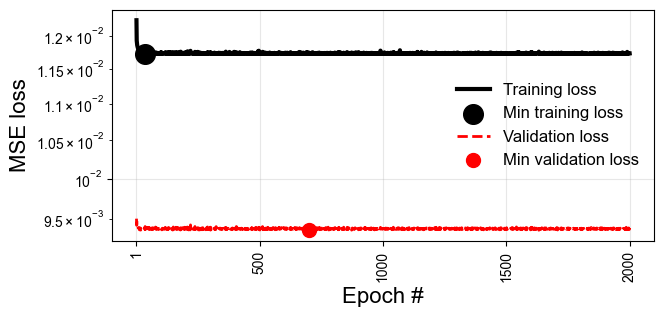

In [26]:
qoi_aware_linear_decoding.plot_losses(markevery=500, figure_size=(7,3))

In [27]:
basis_linear_decoding = qoi_aware_linear_decoding.get_best_basis()

Minimum training loss:		0.011719759243230024
Minimum training loss at epoch:	37


In [28]:
basis_linear_decoding

array([[-0.6693969],
       [-0.742905 ]], dtype=float32)

### QoI-aware encoder-decoder with nonlinear decoding of a dependent variable:

In [29]:
qoi_aware_nonlinear_decoding = QoIAwareProjection(dataset_2D_normalized,
                                                  n_components=1,
                                                  projection_independent_outputs=phi_5[:,None],
                                                  activation_decoder='tanh',
                                                  decoder_interior_architecture=(2,2),
                                                  n_epochs=2000,
                                                  random_seed=random_seed)

In [30]:
qoi_aware_nonlinear_decoding.train()

100%|██████████████████████████████████████| 2000/2000 [00:16<00:00, 117.97it/s]


<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/matplotlib/pyplot.py'>

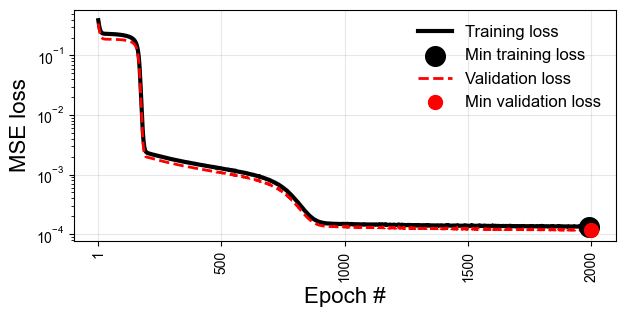

In [31]:
qoi_aware_nonlinear_decoding.plot_losses(markevery=500, figure_size=(7,3))

In [32]:
basis_nonlinear_decoding = qoi_aware_nonlinear_decoding.get_best_basis()

Minimum training loss:		0.00013309478122715114
Minimum training loss at epoch:	1991


In [33]:
basis_nonlinear_decoding

array([[ 0.7368858],
       [-0.6760173]], dtype=float32)

<a id=visualize-1D-projections></a>
***

## Visualize 1D projections

[Go to the top ↑](#top-page)

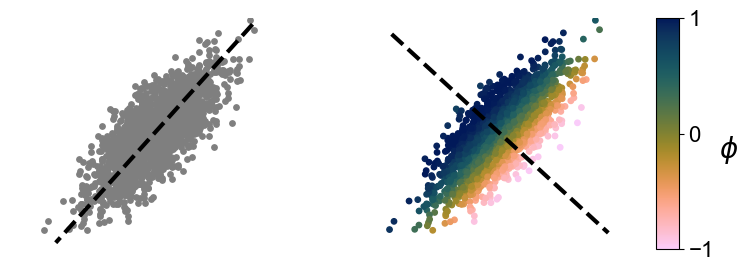

In [34]:
cmap = cmc.batlow_r

fig = plt.figure(figsize=(9, 3))
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1,1.2], height_ratios=[1])

point_size = 15

subspace_color = '#ff0000'
subspace_color = 'k'

figure_a = fig.add_subplot(spec[0,0])
plt.scatter(dataset_2D_normalized[:,0],
            dataset_2D_normalized[:,1],
            s=point_size,
            c='#7f7f7f')
plt.axis('equal');
plt.xticks([])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
basis_PCA = np.array([[np.sqrt(2),np.sqrt(2)], [np.sqrt(2),np.sqrt(2)]])
plt.plot([-basis_linear_decoding[0,0]*1.4, basis_linear_decoding[0,0]*1.4], [-basis_linear_decoding[1,0]*1.4, basis_linear_decoding[1,0]*1.4], '--', c=subspace_color, lw=3)
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])

figure_b = fig.add_subplot(spec[0,1])
scat = plt.scatter(dataset_2D_normalized[:,0], 
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=phi_5_normalized, cmap=cmap)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
basis_optimized = np.array([[-np.sqrt(2),np.sqrt(2)], [np.sqrt(2),np.sqrt(2)]])
plt.plot([-basis_nonlinear_decoding[0,0]*1.4, basis_nonlinear_decoding[0,0]*1.4], [-basis_nonlinear_decoding[1,0]*1.4, basis_nonlinear_decoding[1,0]*1.4], '--', c=subspace_color, lw=3)
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
cbar = plt.colorbar(scat, ticks=[-1,0,1], aspect=10)
cbar.set_label('$\phi$', fontsize=20, rotation=0, horizontalalignment='left', **csfont)
for t in cbar.ax.get_yticklabels():
    t.set_fontproperties('Arial')
    t.set_fontsize(16)
    
plt.savefig(plot_save_location + 'linear-vs-nonlinear-decoders.png', dpi=400, bbox_inches='tight')

In [35]:
if os.path.exists(results_save_location + 'synthetic-dataset-costs-phi-5.csv'):
        
    costs_phi_5 = pd.read_csv(results_save_location + 'synthetic-dataset-costs-phi-5.csv', sep = ',', header=None).to_numpy()

else:
    
    tic = time.perf_counter()
    
    costs_phi_5 = []
    
    for angle in angle_list:
    
        if angle%10==0: print('Angle:\t' + str(angle) + ' degrees')
    
        theta = np.deg2rad(angle)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        x_hat = np.array([1, 0])
        basis_vector = np.dot(rotation_matrix, x_hat)[:,None]
    
        data_projection = np.dot(dataset_2D_normalized, basis_vector)
    
        variance_data = analysis.compute_normalized_variance(data_projection,
                                                             phi_5_normalized,
                                                             depvar_names=['phi'],
                                                             scale_unit_box=True,
                                                             bandwidth_values=bandwidth_values)
    
        cost = analysis.cost_function_normalized_variance_derivative(variance_data,
                                                                     penalty_function='log-sigma-over-peak',
                                                                     norm=None,
                                                                     integrate_to_peak=False)
    
        costs_phi_5.append(cost)
    
        np.savetxt(results_save_location + 'synthetic-dataset-costs-phi-5.csv', (costs_phi_5), delimiter=',', fmt='%.16e')
    
    print('= '*30)
    
    toc = time.perf_counter()
    
    print(f'\n\nTotal time it took: {(toc - tic)/60:0.1f} minutes.')

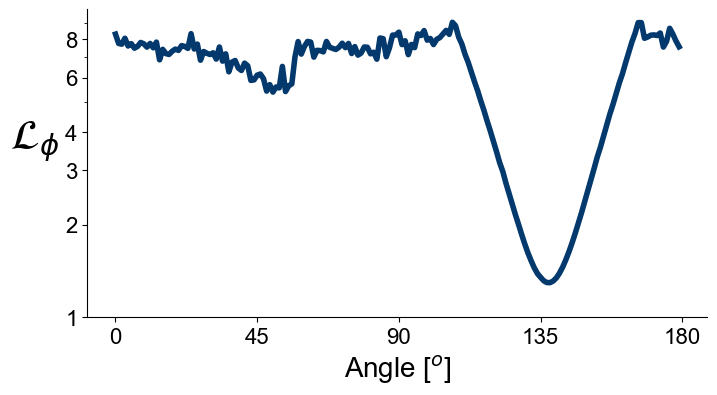

In [36]:
fig = plt.figure(figsize=(8, 4))
spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=[1], height_ratios=[1])

lw = 4
s = 200

figure_c = fig.add_subplot(spec[0,0])
plt.semilogy(angle_list, costs_phi_5, '-', lw=lw, zorder=5, color='#03396c')
plt.ylim([1,10])
plt.yticks([1,2,3,4,6,8], **csfont, fontsize=16)
figure_c.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks([0,45,90,135,180], **csfont, fontsize=16)
plt.xlabel('Angle [$^o$]', fontsize=20, **csfont)
plt.ylabel('$\mathcal{L}_{\phi}$', fontsize=30, rotation=0, horizontalalignment='right', **csfont)
plt.savefig(plot_save_location + 'linear-vs-nonlinear-decoders-costs.svg', dpi=400, bbox_inches='tight')

***